# Demo: Herramienta de evaluación de campos

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import dateparser 
import matplotlib.pyplot as plt

import seaborn as sns

import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from scipy.optimize import minimize

from datetime import datetime, timedelta,date
%matplotlib inline

import cashflows as cf

import timeit
import warnings

In [2]:
plt.style.use('seaborn-white')

pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

warnings.filterwarnings("ignore")

## Módulo Productividad

In [3]:
##################    CARGA DE BASE DE DATOS DE CNH   ######################

def carga_bd():
    
    global mx_bd
    
    tic=timeit.default_timer()
    
    mx_bd=pd.read_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/mexico/mx_bd.csv',
                          usecols=['fecha',
                                  'pozo',
                                  'aceite_Mbd',
                                  'gas_asociado_MMpcd',
                                  'gas_no_asociado_MMpcd',
                                  'condensado_Mbd',
                                  'agua_Mbd',
                                  'estado actual',
                                  'profundidad_total',
                                  'profundidad_vertical',
                                  'trayectoria', 
                                  'ano_perforacion',
                                  'hidrocarburo',
                                  'clasificacion',
                                  'disponible',
                                  'campo',
                                  'cuenca', 
                                  'entidad',  
                                  'ubicacion',
                                  'asignacion'],
                             low_memory=False)
    
    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

carga_bd()

'Tiempo de procesamiento: 16.832288600000002 segundos'

In [28]:
##################    FUNCIÓN DE PRODUCTIVIDAD   ######################

def productividad(hidrocarburo,baja,media,alta):
    
    global unique_well_list
    global perfil
    global df
    global estadistica
    global tipo1
    global tipo2
    global tipo3
    global ajuste
    
    tic=timeit.default_timer()
    
    
##################    INPUT CAMPO   ######################
    
    #input de campo de analisis
    def campo_analisis():
        
        global input_campo
        global campo
        global len_proy
        global nequip
        global cap
        global reservas
    
        #Input de campo
        input_campo = input("Nombre de campo: ")
        #len_proy=input('Duracion del contrato: ')
        #nequip=input('Numero de equipos: ')
        #cap=input('Capacidad de procesamiento (Mbd: ')
        #reservas=input('Reservas: ')
        
        len_proy=500
        nequip=2
        cap=5_000
        reservas=1_000_000

        seleccion=mx_bd.pozo.str.contains(str(input_campo))
        campo=mx_bd.loc[seleccion]

        unique_well_list=pd.unique(campo['pozo'])

        display('Número de pozos en ' +str(input_campo)+': '+str(len(unique_well_list)))

        #Generacion de archivo de resultados
        #campo.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))

        return campo, len_proy, nequip, cap, reservas
    

########      FUNCIONES PARA EL ANALISIS DE DECLINACION DE POZOS      ####### 
    
    def remove_nan_and_zeroes_from_columns(df, variable):
        """
        This function cleans up a dataframe by removing rows in a specific 
        column that are null/NaN or equal to 0. This basically removes zero 
        production time periods.
        Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
        Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
        """
        filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
        return filtered_df

    def generate_time_delta_column(df, time_column, date_first_online_column):
        """
        Create column for the time that a well has been online at each reading, with 
        the first non-null month in the series listed as the start of production
        Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
        Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
        """
        df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
        return (df[time_column]-df[date_first_online_column]).dt.days

    def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
 
        """
        This function obtains the min or max value for a column, with a group by applied. For example,
        it could return the earliest (min) RecordDate for each API number in a dataframe 
        Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
        Outputs:
        value: Depends on the calc_column type.
        """
        value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
        return value

    def get_max_initial_production(df, number_first_months, variable_column, date_column):

        """
        This function allows you to look at the first X months of production, and selects 
        the highest production month as max initial production
        Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
        """
        #First, sort the data frame from earliest to most recent prod date
        df=df.sort_values(by=date_column)
        #Pull out the first x months of production, where number_first_months is x
        df_beginning_production=df.head(number_first_months)
        #Return the max value in the selected variable column from the newly created 
        #df_beginning_production df
        return df_beginning_production[variable_column].max()

    def hiperbolica(t, qi, b, di):
        """
        Hyperbolic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/((1.0+b*di*t)**(1.0/b))

    def exponencial(t, qi, di):
        """
        Exponential decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi*np.exp(-di*t)

    def harmonica(t, qi, di):
        """
        Harmonic decline curve equation
        Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        Output: 
        Returns q, or the expected production rate at time t. Float.
        """
        return qi/(1+(di*t))

    def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
        """
        This function is used to map x- and y-variables against each other
        Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
        """
        #Plot resultados
        df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
        plt.show()
    
    
#############     ANÁLISIS DE DECLINACION DE POZOS (DCA)   #############

    def analisis_dca():
        
        global resultados, gasto
        
        resultados=pd.DataFrame()
        gasto=pd.DataFrame()
        Qi=pd.DataFrame()
        
        #Entrada de campo de análisis
        campo_analisis()
        data_pozos=campo
        
        #Limpieza de datos y formato de fecha
        data_pozos['fecha']=pd.to_datetime(data_pozos['fecha'])
        
        #hidrocarburo de análisis
        hydrocarbon=str(hidrocarburo)
        
        #Remove all rows with null values in the desired time series column
        data_pozos=remove_nan_and_zeroes_from_columns(data_pozos, hydrocarbon)
        
        #Get a list of unique wells to loop through
        unique_well_list=pd.unique(list(data_pozos.pozo))
        
        #Get the earliest RecordDate for each Well
        data_pozos['first_oil']= get_min_or_max_value_in_column_by_group(data_pozos, group_by_column='pozo', 
                                                                        calc_column='fecha', calc_type='min')
        #Generate column for time online delta
        data_pozos['days_online']=generate_time_delta_column(data_pozos, time_column='fecha', 
                      date_first_online_column='first_oil')
        #Pull data that came online between an specified range
        data_pozos_range=data_pozos[(data_pozos.fecha>='1900-01-01') & (data_pozos.fecha<='2019-12-01')]
        
        #Loop para realizar el DCA en cada pozo del campo
        for pozo in unique_well_list:
            
            #Subset del data frame del campo por pozo
            serie_produccion=data_pozos_range[data_pozos_range.pozo==pozo]
            
            #Calculo de declinacion porcentual
            serie_produccion['declinacion']=serie_produccion[hidrocarburo].pct_change(periods=1)
            
            #Cálculo de la máxima producción inicial
            qi=get_max_initial_production(serie_produccion, 500, hydrocarbon, 'fecha')
            
            #Columna de mes de producción
            serie_produccion.loc[:,'mes']=(serie_produccion[hidrocarburo] > 0).cumsum()
    
            #Ajuste Exponencial
            #popt_exp, pcov_exp=curve_fit(exponencial, serie_produccion['mes'], 
             #                            serie_produccion[hydrocarbon],bounds=(0, [qi,50]))
            #print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))

            #Ajuste Hiperbolico
            popt_hyp, pcov_hyp=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[hydrocarbon],bounds=(0, [qi,1,50]))
            #print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
           
            #Ajuste Harmonico
            popt_harm, pcov_harm=curve_fit(harmonica, serie_produccion['mes'], 
                                         serie_produccion[hydrocarbon],bounds=(0, [qi,50]))
            #print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))
    
            #Resultados de funcion Exponencial
            #serie_produccion.loc[:,'exponencial']=exponencial(serie_produccion['mes'], 
             #                     *popt_exp)
            
            #Resultados de funcion Hiperbolica
            serie_produccion.loc[:,'hiperbolica']=hiperbolica(serie_produccion['mes'], 
                                      *popt_hyp)
            #Resultados de funcion Harmonica
            serie_produccion.loc[:,'harmonica']=harmonica(serie_produccion['mes'], 
                                      *popt_harm)
            
            #Error
            perr_hyp = np.sqrt(np.diag(pcov_hyp))
            perr_harm = np.sqrt(np.diag(pcov_harm))
                
            seleccion_base=serie_produccion[serie_produccion.fecha == serie_produccion.fecha.max()]
       
            Qi=[[pozo,
                 qi,
                 popt_hyp[0],
                 popt_hyp[1],
                 popt_hyp[2],
                 perr_hyp[0],
                 perr_hyp[1],
                 popt_harm[0],
                 popt_harm[1],
                 perr_harm[0],
                 perr_harm[1],
                 seleccion_base[hidrocarburo],
                 seleccion_base.mes,
                 seleccion_base.profundidad_vertical,
                 str(seleccion_base.trayectoria)]]
    
            #Plot del Análisis de Declinación de Curvas (DCA)
            #Declare the x- and y- variables that we want to plot against each other
            y_variables=[hydrocarbon,'harmonica','hiperbolica']
            x_variable='mes'
            
            #Create the plot title
            plot_title=hydrocarbon+' for '+str(pozo)
            
            #Plot the data to visualize the equation fit
            #plot_actual_vs_predicted_by_equations(serie_produccion, x_variable, y_variables, plot_title)
    
            
            #Resultados de DCA
            resultados=resultados.append(serie_produccion,sort=False)
            gasto=gasto.append(Qi,sort=True)
            
        
        gasto=gasto.rename(columns={0:'pozo',
                                    1:'Qi_hist',
                                    2:'Qi_hyp',
                                    3:'b',
                                    4:'di_hyp',
                                    5:'error_Qi_hyp',
                                    6:'error_di_hyp',
                                    7:'Qi_harm',
                                    8:'di_harm',
                                    9:'error_Qi_harm',
                                   10:'error_di_harm',
                                   11:hidrocarburo,
                                   12:'mes',
                                   13:'profundidad_vertical',
                                   14:'trayectoria'})
        
        estadistica=resultados.describe()
        
        #resultados.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
        #gasto.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/gasto.csv')
                
        return resultados, gasto
        
    analisis_dca()
    
#########################  POZOS TIPO - PRONOSTICO DE PRODUCCION Qo   ##################### 
    
    periodo=np.arange(start=1,stop=501,step=1)
    fechas=pd.date_range(start='01-Jan-2020',freq='M',periods=500,normalize=True,closed='left')

    df=pd.DataFrame()

    df['fecha']=fechas
    df['mes']=pd.DatetimeIndex(fechas).month
    df['ano']=pd.DatetimeIndex(fechas).year
    df['dias']=pd.DatetimeIndex(fechas).day
    df['periodo']=periodo
    
    q_baja=gasto.Qi_hist.quantile(baja)
    q_media=gasto.Qi_hist.quantile(media)
    q_alta=gasto.Qi_hist.quantile(alta)
    
    #d_baja=gasto.di.quantile(baja)
    d_media=gasto.di_hyp.quantile(media)
    #d_media=gasto.di_harm.quantile(media)
    #d_alta=gasto.di.quantile(alta)
    
    d=gasto.di_hyp.mean()
    #d=gasto.di_harm.mean()
    b=gasto.b.mean()  

    criterio1=(gasto['Qi_hist'] <= q_baja)
    tipo1=gasto.loc[criterio1]
    
    
    #q_baja_1=tipo1.Qi_hist.quantile(baja)
    q_media_1=tipo1.Qi_hist.quantile(media)
    #q_alta_1=tipo1.Qi_hist.quantile(alta)
    
    #d_baja_1=tipo1.di.quantile(baja)
    d_media_1=tipo1.di_hyp.quantile(media)
    #d_media_1=tipo1.di_harm.quantile(media)
    #d_alta_1=tipo1.di.quantile(alta)
    
    d1=tipo1.di_hyp.mean()
    #d1=tipo1.di_harm.mean()
    b1=tipo1.b.mean()
    
    criterio2=(gasto['Qi_hist'] > q_baja) & (gasto['Qi_hist'] < q_alta)
    tipo2=gasto.loc[criterio2]
    
    
    #q_baja_2=tipo2.Qi_hist.quantile(baja)
    q_media_2=tipo2.Qi_hist.quantile(media)
    #q_alta_2=tipo2.Qi_hist.quantile(alta)
    
    #d_baja_2=tipo2.di.quantile(baja)
    d_media_2=tipo2.di_hyp.quantile(media)
    #d_media_2=tipo2.di_harm.quantile(media)
    #d_alta_2=tipo2.di.quantile(alta)
    
    d2=tipo2.di_hyp.mean()
    #d2=tipo2.di_harm.mean()
    b2=tipo2.b.mean()    
    
    criterio3=(gasto['Qi_hist'] >= q_alta)
    tipo3=gasto.loc[criterio3]
    
    #q_baja_3=tipo3.Qi_hist.quantile(baja)
    q_media_3=tipo3.Qi_hist.quantile(media)
    #q_alta_3=tipo3.Qi_hist.quantile(alta)
    
    #d_baja_3=tipo3.di.quantile(baja)
    d_media_3=tipo3.di_hyp.quantile(media)
    #d_media_3=tipo3.di_harm.quantile(media)
    #d_alta_3=tipo3.di.quantile(alta)
    
    d3=tipo3.di_hyp.mean()
    #d3=tipo3.di_harm.mean()
    b3=tipo3.b.mean()    
    
    perfil=pd.DataFrame()
    
    for x in df:
        
        perfil['mes']=df.periodo
        #perfil['P50_BAJA']=(q_baja/((1.0+b*d*df.periodo)**(1.0/b)))
        #perfil['P50']=(q_media/((1.0+b*d*df.periodo)**(1.0/b)))
        #perfil['P50_ALTA']=(q_alta/((1.0+b*d*df.periodo)**(1.0/b)))
        #perfil['Np']=((q_media**b)/((b-1)*d))*((perfil.P50_MEDIA**(1-b))-(q_media**(1-b)))

        #perfil['P1_BAJA']=(q_baja_1/((1.0+b1*d1*df.periodo)**(1.0/b1)))
        perfil['tipo1_baja']=(q_media_1/((1.0+b1*d1*df.periodo)**(1.0/b1)))
        #perfil['P1_ALTA']=(q_alta_1/((1.0+b1*d1*df.periodo)**(1.0/b1)))

        #perfil['P2_BAJA']=(q_baja_2/((1.0+b2*d2*df.periodo)**(1.0/b2)))
        perfil['tipo2_media']=(q_media_2/((1.0+b2*d2*df.periodo)**(1.0/b2)))
        #perfil['P2_ALTA']=(q_alta_2/((1.0+b2*d2*df.periodo)**(1.0/b2)))
        
        #perfil['P3_BAJA']=(q_baja_3/((1.0+b3*d3*df.periodo)**(1.0/b3)))
        perfil['tipo3_alta']=(q_media_3/((1.0+b3*d3*df.periodo)**(1.0/b3)))
        #perfil['P3_ALTA']=(q_alta_3/((1.0+b3*d3*df.periodo)**(1.0/b3)))
        
        #perfil['agregado']=(.20)*perfil.P1_MEDIA+(.50)*perfil.P2_MEDIA+(.20)*perfil.P3_MEDIA

    d = {'Qi_hist': [tipo1.Qi_hist.mean(), tipo2.Qi_hist.mean(),tipo3.Qi_hist.mean()],
         'Qi_hyp': [tipo1.Qi_hyp.mean(), tipo2.Qi_hyp.mean(),tipo3.Qi_hyp.mean()],
         'Qi_harm': [tipo1.Qi_harm.mean(), tipo2.Qi_harm.mean(),tipo3.Qi_harm.mean()],
         'b': [tipo1.b.mean(), tipo2.b.mean(),tipo3.b.mean()],
         'di_hyp': [tipo1.di_hyp.mean(), tipo2.di_hyp.mean(),tipo3.di_hyp.mean()],
         'di_harm': [tipo1.di_harm.mean(), tipo2.di_harm.mean(),tipo3.di_harm.mean()],
         'error_Qi_hyp':[tipo1.error_Qi_hyp.mean(), tipo2.error_Qi_hyp.mean(),tipo3.error_Qi_hyp.mean()],
         'error_Qi_harm':[tipo1.error_Qi_harm.mean(), tipo2.error_Qi_harm.mean(),tipo3.error_Qi_harm.mean()],
         'error_di_hyp':[tipo1.error_di_hyp.mean(), tipo2.error_di_hyp.mean(),tipo3.error_di_hyp.mean()],
         'error_di_harm':[tipo1.error_di_harm.mean(), tipo2.error_di_harm.mean(),tipo3.error_di_harm.mean()]}
    
    ajuste = pd.DataFrame(data=d,index=['tipo1','tipo2','tipo3'])
    ajuste.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/parametros.csv')
        
    #perfil.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/perfl_'+str(input_campo)+'.csv')
    perfil=perfil.set_index('mes')
    perfil.to_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/perfiles_tipo.csv')
    
    #display('Qi50 del campo:  '+str(gasto.Qi_hist.quantile(.5)),
     #       'Qi50 del Pozo Tipo 1:  '+str(tipo1.Qi_hist.quantile(.5)),
      #      'Qi50 del Pozo Tipo 2:  '+str(tipo2.Qi_hist.quantile(.5)),
       #     'Qi50 del Pozo Tipo 3:  '+str(tipo3.Qi_hist.quantile(.5)))

    #display('d_media del campo:  '+str(gasto.di_harm.quantile(.5)),
     #       'd_media hyp del Pozo Tipo 1:  '+str(tipo1.di_hyp.quantile(.5)),
      #      'd_media hyp del Pozo Tipo 2:  '+str(tipo2.di_hyp.quantile(.5)),
       #     'd_media hyp del Pozo Tipo 3:  '+str(tipo3.di_hyp.quantile(.5)),
        #    'd_media harm del Pozo Tipo 1:  '+str(tipo1.di_harm.quantile(.5)),
         #   'd_media harm del Pozo Tipo 2:  '+str(tipo2.di_harm.quantile(.5)),
          #  'd_media harm del Pozo Tipo 3:  '+str(tipo3.di_harm.quantile(.5)))
      
    distribucion=pd.DataFrame(data={'numero_pozos': [len(tipo1),len(tipo2),len(tipo3)]},
                              index=['tipo1','tipo2','tipo3'])
    
    

#########################  GRAFICAS DE RESULTADOS   ##################### 

    #Estadistica descriptiva
        
    #display('Percentiles y estadistica descriptiva: ')
    #display(campo[hidrocarburo].quantile([.1,.5,.9]), campo.describe())  
    
    #Analisis de dispersion
    #campo=campo.sort_values(by='profundidad_vertical')
    #fig, ax = plt.subplots(figsize=(10,5))
    #ax.scatter(campo[hidrocarburo],campo.profundidad_vertical,color='Black')
    #plt.title('Gasto de '+str(hidrocarburo)+' vs profundidad vertical para el campo '+str(input_campo))
    #ax.set_xlabel(hidrocarburo)
    #ax.set_ylabel('Profundidad vertical')
    #plt.show()
    
    #Ajuste de distribucion
    #dst=Distribution()
    #display(dst.Fit(campo['aceite_Mbd']))
    #dst.Plot(campo['aceite_Mbd'])
    
    #Distribucion del gasto inicial Qi
    fig0, ax0 = plt.subplots(figsize=(10,5))
    plt.hist(gasto.Qi_hist, alpha=0.5, label='Qi_hist',density=True)
    plt.title('Histograma del gasto inicial del campo ' +str(input_campo))
    plt.legend(loc='upper right')
    
    #Distribucion de la declinacion inicial di
    fig1, ax1 = plt.subplots(figsize=(10,5))
    plt.hist(gasto.di_hyp, alpha=0.5, label='di',color='Green',density=True)
    plt.title('Histograma de la declinacion inicial del campo ' +str(input_campo))
    plt.legend(loc='upper right')
    
    #Distribucion del gasto historico vs pronosticado
    fig2, ax2 = plt.subplots(figsize=(10,5))
    plt.hist(resultados[hidrocarburo], alpha=0.5, label='Qo historico',density=True)
    plt.hist(resultados.hiperbolica, alpha=0.5, label='Hyperbolic Predicted',density=True)#,cumulative=True)
    plt.hist(resultados.harmonica, alpha=0.5, label='Harmonic Predicted',density=True)
    plt.title('Distribucion del gasto historico vs pronosticado ' +str(input_campo))
    plt.legend(loc='upper right')
    
    #Pie chart de distribucion de Pozos Tipo 
    #labels = 'Baja', 'Media', 'Alta'
    #explode = (0.1, 0.1, 0.1) 
    #fig3, ax3 = plt.subplots(figsize=(10,5))
    #ax3.pie(distribucion, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
    #ax3.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    #plt.show()
    
    #Dispersion del gasto inicial Qi
    fig4, ax4 = plt.subplots(figsize=(10,5))
    ax4.scatter(tipo1.Qi_hist,tipo1.pozo,color='Red',label='Pozo Tipo 1 - BAJA')
    ax4.scatter(tipo2.Qi_hist,tipo2.pozo,color='Blue',label='Pozo Tipo 2 - MEDIA')
    ax4.scatter(tipo3.Qi_hist,tipo3.pozo,color='Green',label='Pozo Tipo 3 - ALTA')
    ax4.set_xlabel('Gasto inicial Qi')
    ax4.set_ylabel('Pozo')
    plt.title('Dispersion del gasto inicial del campo ' +str(input_campo) +' por pozo')
    plt.legend(loc='upper right')
    plt.show()
    
    #Dispersion del gasto inicial Qi vs Profundidad Vertical
    fig7, ax7 = plt.subplots(figsize=(10,5))
    ax7.scatter(tipo1.Qi_hist,tipo1.profundidad_vertical,color='Red',alpha=0.5,label='Pozo Tipo 1 - BAJA')
    ax7.scatter(tipo2.Qi_hist,tipo2.profundidad_vertical,color='Blue',alpha=0.5,label='Pozo Tipo 2 - MEDIA')
    ax7.scatter(tipo3.Qi_hist,tipo3.profundidad_vertical,color='Green',alpha=0.5,label='Pozo Tipo 3 - ALTA')
    ax7.set_xlabel('Gasto inicial Qi')
    ax7.set_ylabel('Profundidad Vertical')
    plt.title('Dispersion del gasto inicial del campo ' +str(input_campo) +' vs Profundidad Vertical')
    plt.legend(loc='upper right')
    plt.show()
    
    #Dispersion del gasto inicial Qi vs Trayectoria
    #fig8, ax8 = plt.subplots(figsize=(10,5))
    #ax8.scatter(tipo1.Qi_hist,tipo1.trayectoria,color='Red',label='Pozo Tipo 1 - BAJA')
    #ax8.scatter(tipo2.Qi_hist,tipo2.trayectoria,color='Blue',label='Pozo Tipo 2 - MEDIA')
    #ax8.scatter(tipo3.Qi_hist,tipo3.trayectoria,color='Green',label='Pozo Tipo 3 - ALTA')
    #ax8.set_xlabel('Gasto inicial Qi')
    #ax8.set_ylabel('Trayectoria')
    #plt.title('Dispersion del gasto inicial del campo ' +str(input_campo))
    #plt.legend(loc='upper right')
    #plt.show()
    
    #Tiempo de produccion vs Gasto de hidrocarburo
    #resultados=resultados.groupby(by='pozo')
    fig5, ax5 = plt.subplots(figsize=(10,5))
    ax5.scatter(resultados.mes, resultados[hidrocarburo],color='Gray',alpha=0.5)
    plt.title('Gasto de ' +str(hidrocarburo)+' vs Tiempo de Producción')
    ax5.set_xlabel('Mes')
    ax5.set_ylabel('Qo')
    plt.show()
    
    #fig9, ax9 = plt.subplots(figsize=(10,5))
    #ax9.scatter(resultados.trayectoria,resultados[hidrocarburo],color='Gray',alpha=0.5)
    #plt.title('Trayectoria vs Gasto de ' +str(hidrocarburo))
    #ax9.set_xlabel('Trayectoria')
    #ax9.set_ylabel('Qo')
    #plt.show()

    #Perfiles de pozos tipo
    fig6, ax6 = plt.subplots(figsize=(10,5))    
    #ax6.plot(perfil.P_BAJA,label='Qo-P_BAJA')
    #ax6.plot(perfil.P50_MEDIA,label='Qo-P_MEDIA',linestyle='dashdot')
    #ax6.plot(perfil.P_ALTA,label='Qo-P_ALTA')
    #ax6.plot(perfil.P1_BAJA,label='Qo1-BAJA_L')
    ax6.plot(perfil.tipo1_baja,label='Qo1-BAJA',linestyle='dotted',color='red')
    #ax6.plot(perfil.P1_ALTA,label='Qo1-BAJA_H')
    #ax6.plot(perfil.P2_BAJA,label='Qo2-MEDIA_L')
    ax6.plot(perfil.tipo2_media,label='Qo2-MEDIA',linestyle='solid',color='blue')
    #ax6.plot(perfil.P2_ALTA,label='Qo2-MEDIA_H')
    #ax6.plot(perfil.P3_BAJA,label='Qo3-ALTA_L')
    ax6.plot(perfil.tipo3_alta,label='Qo3-ALTA',linestyle='dashed',color='green')
    #ax6.plot(perfil.P3_ALTA,label='Qo3-ALTA_H')
    ax6.set_xlabel('Mes')
    ax6.set_ylabel('Qo')
    #plt.yscale('log')
    plt.xlim(0,500)
    plt.ylim(0);
    plt.title('Pronostico de produccion para pozo tipo en el campo ' +str(input_campo))
    plt.legend(loc='upper right')
    plt.show()

    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')

Nombre de campo: SIHIL


'Número de pozos en SIHIL: 28'

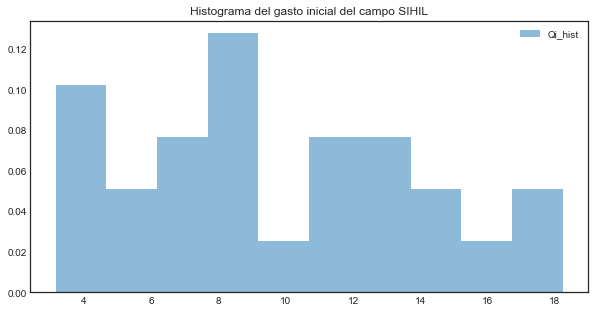

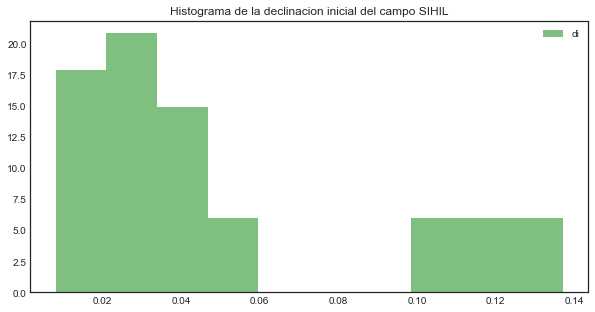

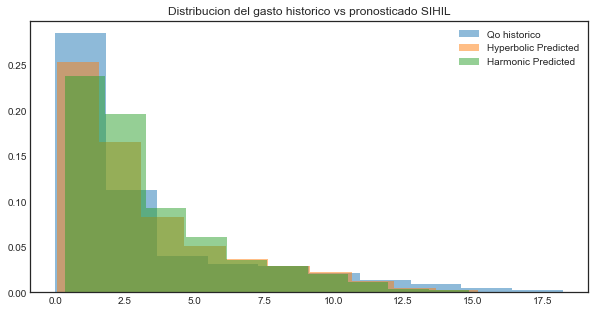

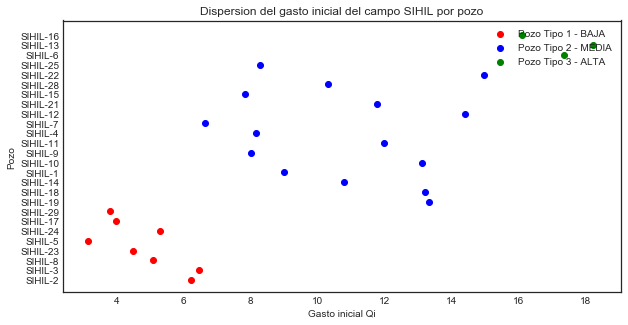

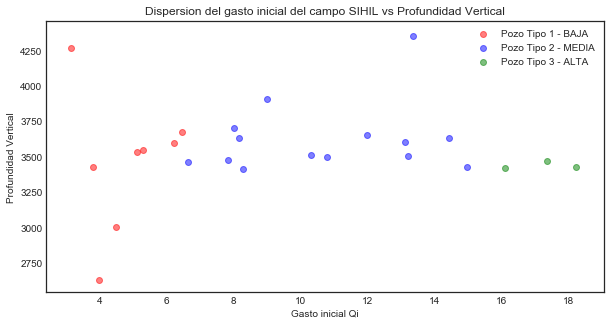

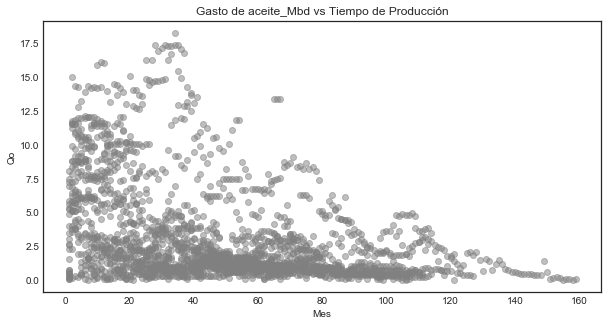

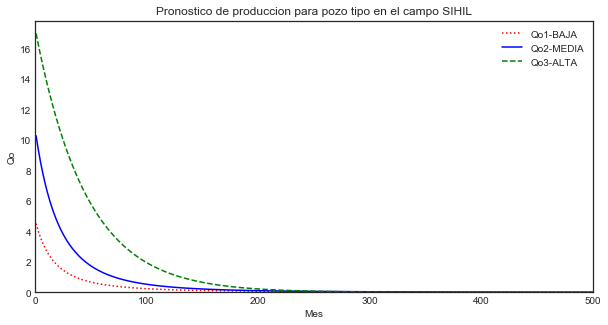

'Tiempo de procesamiento: 20.050448499999675 segundos'

In [29]:
productividad('aceite_Mbd',0.30,0.50,0.90)

## Módulo Perforación

NameError: name 'bd' is not defined

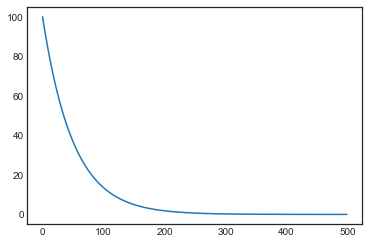

In [31]:
#######################     OPTIMIZACIÓN DE PERFORACIÓN     ##################

def exp_curve(q0,a,t):
    if t>=0:
        x=q0*np.exp(-1*a*t)
        return x
    else:
        x=0
        return x

t=pd.Series(range(0,len_proy))
pt1=[exp_curve(100,.02,x) for x in t.index]
plt.plot(pt1)

perf=np.array([0,0])


def np_perf(perf,len_proy=200):
        Np=pd.Series(0,index=range(0,len_proy))
        for i in perf:
            Np=Np+[exp_curve(100,.02,x-i) for x in Np.index]
        return(Np)


def objfunction(Np,limit=200,len_proy=200):
    x=pd.Series(1,index=range(0,len_proy))
    x=x*200
    sumsquared=sum([(x[i]-Np[i])**2 for i in x.index])
    return(sumsquared)
    
    
def funoptim(perf):
    Np=np_perf(perf)
    x=objfunction(Np)
    return(x)
    
    
x0=perf
cons=({'type': 'ineq', 'fun': lambda x:   x[0]-2-x[1]})
bnds=((0,200),(None,200))
x=minimize(funoptim,(0,0),method='SLSQP',constraints=cons,bounds=bnds)


x=bd.groupby(["fecha","nivel","numero_de_asignacion","entidad","categoria_de_reserva"]).agg(sum)

#plt.plot_date(bd.fecha[(bd.numero_de_asignacion=="A-0001") & (bd.entidad=="Abkatun-228" )& (bd.categoria_de_reserva=="PRB")],bd.aceite[(bd.numero_de_asignacion=="A-0001") & (bd.entidad=="Abkatun-228" )& (bd.categoria_de_reserva=="PRB")])


bd=pd.read_csv("C:/Users/joser/Downloads/kumaza_dca.csv")
    
    
bd.fecha=[dateparser.parse(x,languages=['en'],
                     date_formats=['%Y-%m-%d']) for x in bd.fecha]


x=bd.pivot(index="fecha",columns="pozo",values="aceite_Mbd")
x=x[x.index>= '2000-09-01']
x.plot()
plt.savefig(str(input_campo)+".png",dpi=300)

y=bd.groupby("fecha").aceite_Mbd.sum()


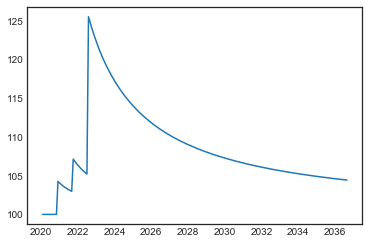

In [37]:
#welltype=pd.DataFrame({"q0":[pt.iloc[0,0],pt.iloc[1,0],pt.iloc[2,0]],
 #                      "b":[pt.iloc[0,3],pt.iloc[1,3],pt.iloc[2,3]],
  #                     "di":[pt.iloc[0,4],pt.iloc[1,4],pt.iloc[2,4]],
   #                    "tp":[10,20,5],
    #                   "type":["exp","hyp","hyp"]},index=pt.index)

pt=pd.read_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/parametros.csv')

len_proy=200
fecha=pd.date_range(start="2020-01-31", periods=len_proy,freq="M").to_pydatetime().tolist()
welltype=pd.DataFrame({"q0":[100,150,75],"a":[.05,.05,.1],"tp":[10,20,5],"b":[1,2,1],"type":["exp","hyp","hyp"]})
costs=pd.DataFrame({"fixed":[300,300,100],"per_barrel":[4.5,1,2]})
costs_base=4.5
base=pd.Series(100,index=range(0,len_proy))

drillorder=[0,1,0,2,2,1]

def seleccion_curva(pt):
    
    curve=["harm"]*(pt.index.max()+1)
    curve=pd.DataFrame(curve)
    curve.loc[pt.iloc[:,-2]<pt.iloc[:,-1]]="hyp" 
    curve=curve.rename(columns={0:"type"})
    return curve 
curve_type=seleccion_curva(pt)
pt=pd.concat([pt,seleccion_curva(pt)],axis=1)
pt=pd.concat([pt,pd.DataFrame({"tp":[10,10,10]})],axis=1)


welltype=pt
##función de producción
def exp_curve(welltype,t):
    if t-welltype.tp>=0:
        x=welltype.Qi*np.exp(-1*welltype.dy_hyp*(t-welltype.tp))
        return x
    else:
        x=0
        return x
    
    
def hyperbolic_curve(welltype,t):

    if t-welltype.tp>=0:
        if welltype.type=="harm":
            x=welltype.Qi_harm/((1.0+welltype.di_harm*t))
        else:
            x=welltype.Qi_hyp/((1.0+welltype.b*welltype.di_hyp*t)**(1.0/welltype.b))   
        return x
    else: 
        x=0
        return x 


def dec_curve(welltype,t):
    
    if welltype.type=="exp":
        return exp_curve(welltype,t) 
    else:
        return hyperbolic_curve(welltype,t)

def np_perf(perf,welltype,len_proy=200):
        for i in perf:
            Np=Np+[dec_curve(welltype,x-i) for x in Np.index]
            Np[Np<0]=0
            
        return(Np)
        

##funcion tren perforacion
def np_func(welltype,drillorder,costs,costs_base,nequip=1,len_proy=200,cap=500,reservas=1000000,base=None):
    
    t=range(0,len_proy)
    perf=[]
    Np=base
    costovar=pd.Series(0,index=range(0,len_proy))
    if any(Np==None):
        Np=pd.Series(0,index=range(0,len_proy))    
    else:
        costovar=costs_base*Np
        
    capex=pd.Series(0,index=range(0,len_proy))
    equipdisp=np.ones((nequip,len_proy),dtype=int)
    nwells=len(drillorder)

    w=0
    ind_welltype=drillorder[w]
    for j in range(0,len(t)):
        
        if w>=nwells:
            break
        ind_welltype=drillorder[w]
        
        if all(equipdisp[:,j]==0):
            next 
        while (any(equipdisp[:,j]==1) and len(perf)<nwells):
            Np_trial=pd.Series(Np)
            Np_trial=Np_trial+[dec_curve(welltype.loc[ind_welltype,:],x-j) for x in Np_trial.index]
            Np_trial[Np_trial<0]=0
            if Np_trial.max()>=cap:
                break 
            costovar_trial=(Np_trial-Np)*costs.loc[ind_welltype,:].per_barrel*[x.day for x in fecha]
            costovar=costovar+costovar_trial
            Np=pd.Series(Np_trial)
            tp=welltype.iloc[ind_welltype,:].tp.astype(int)
            equipdisp[np.min(np.where(equipdisp[:,j]==1)),j:j+tp]=0
            perf.append(j)
            w=w+1
            
    Np[np.cumsum(Np*30)>=reservas]=0
    costovar[np.cumsum(Np*30)>=reservas]=0
    
    for z in perf:
        i=0
        capex_trial=pd.Series(0,index=range(0,len_proy))
        capex_trial.iloc[z]=costs.fixed[drillorder[i]]
        capex=capex+capex_trial
        i=i+1
        
    return([Np,costovar,capex,perf])
    

Np=np_func(welltype,drillorder,costs,costs_base,nequip=2,len_proy=200,cap=10000,reservas=1000000,base=base)

df=pd.DataFrame({"fecha":fecha,"Np":Np[0],"Capex":Np[2],"Opex":Np[1]})
#plt.plot(df.fecha,df.Np)
plt.plot(df.fecha,df.Np)

#plt.plot(Np.fecha,np.cumsum(Np.Np))

In [38]:
pt=pd.read_csv(r'C:/Users/elias/Google Drive/python/csv/benchmark/parametros.csv',
               index_col=0)

fecha=pd.date_range(start="2020-01-31", periods=len_proy,freq="M").to_pydatetime().tolist()


costs=pd.DataFrame({"fixed":[300,300,100],"per_barrel":[4.5,1,2]})
costs_base=4.5
base=pd.Series(100,index=range(0,len_proy))

drillorder=[0,1,0,2,2,1]

welltype=pt

In [39]:
display(welltype)

,Qi_hist,Qi_hyp,Qi_harm,b,di_hyp,di_harm,error_Qi_hyp,error_Qi_harm,error_di_hyp,error_di_harm
tipo1,4.81,3.99,4.05,0.43,0.06,0.09,0.63,0.67,1.37,0.05
tipo2,10.79,8.73,8.91,0.29,0.05,0.08,0.99,1.17,0.44,0.02
tipo3,17.24,14.26,14.22,0.00,0.02,0.04,1.32,1.76,0.42,0.01


## Módulo Económico

In [40]:
#Modelo Económico Mensualisado

tipo_de_cambio = 20

#Tipo de campo aceite o gas no asociado
tipo_de_campo = "aceite"

#Especificaciones del proyecto
factor_de_conversion = 0
costo_transporte_crudo = 0 #acondicionamiento y transporte aceite
costo_transporte_gas = 0 #acondicionamiento y transporte gas
gravedad_api = 18.60
RGA_pc_b = 6.91
area = 62.61
factor_conversion_volumen = 0 

#Regimen Fiscal
regimen_fiscal = "licencia"

#Indicadores cuota contractual para la etapa exploratoria
duracion_etapa_exploratoria = 0

#Indicadores del impuesto por la actividad de exploración y extracción de hidrocarburos
area_exp = 0 #area contracual de fase de exploración
area_ext = 62.61 #area contractual de fase de extraccion

#Datos contractuales
bono_a_la_firma = 0 
regalia_adicional = .13 #En decimales el porcentaje de regalía adicional para los contratos de licencia

tasa_de_descuento = .10 #En decimal tasa de descuento



#Impuestos Corporativos
tasa_isr = .30


mpp = pd.read_excel(r"C:\Users\elias\OneDrive\Documentos\GitHub\Ainda\Proyecto Newton\04_economico/Prueba_Reporte Salida - (21_05_2019_17_36_18) A-0308- Campo Sihil - 2P.xlsx")
fecha = mpp["Fecha"]

mpp.index = fecha

len_proy = len(mpp["Qo (bd)"])

def headers(data):
    for col in data.columns: 
        print(col)

#Da el acumulado de una serie de python
def acumulado(x):
    acum = pd.Series.sum(x)
    print(acum)

#Regresa el gasto equivalente
def gastoequiv():
    
    if factor_de_conversion == 0:
        gastoequi = (mpp["Qo (bd)"] + mpp["Qc (bd)"])*dias_de_mes/1000000
    else:
        gastoequi = (mpp["Qo (bd)"]+mpp["Qg (Mpcd)"]/factor_de_conversion+mpp["Qc (bd)"])*dias_de_mes/1000000
    return(gastoequi)

#Da la funcion para la matriz de precios
def funprecios(dado, fecha, precio_crudoint = 53.57, precio_gasint = 4.11, precio_condensadoint = 0):
    if dado == 1:
        imputprecios = pd.read_excel(r"C:\Users\elias\OneDrive\Documentos\GitHub\Ainda\Proyecto Newton\04_economico/Perfil de Precios Campo Sihil.xlsx")
        precio_crudo = imputprecios["Precio Aceite (USD/b)"]
        precio_gas = imputprecios["Precio Gas (USD/Mpc)"]
        precio_condensado = imputprecios["Precio Condensado (USD/b)"]
        df = pd.concat([precio_crudo, precio_gas, precio_condensado], axis = 1)
        df = df.rename(columns = {"Precio Aceite (USD/b)" : "crudo", 
                              "Precio Gas (USD/Mpc)":"gas",
                              "Precio Condensado (USD/b)":"condensado" }) 
    else:
        crudo = pd.Series(data = precio_crudoint, index = fecha)
        gas = pd.Series(data = precio_gasint, index = fecha)
        condensado = pd.Series(data = precio_condensadoint, index = fecha)
        df = pd.concat([crudo, gas, condensado], axis = 1) 
        df = df.rename(columns = {0 : "crudo", 
                              1 : "gas",
                              2 : "condensado" })
    return(df)
    
#Calcula el abandono en pagos trimestrales
    
def calculoabandono(abandono_pozos,abandono_infra):
    
    abandono = abandono_pozos + abandono_infra
    totalpozos = pd.Series.sum(abandono_pozos)
    totalinfra = pd.Series.sum(abandono_infra)
    costo_total = totalpozos + totalinfra
    totalboed = pd.Series.sum(gasto_equivalente_boed)
    vectoraux = pd.Series(0, index = fecha)
    cond = (vectoraux.index.month == 12)
    vectoraux[cond] = (gasto_equivalente_boed.rolling(12).sum())/totalboed
    fecha_final = gasto_equivalente_boed.index[0]

    gastoabandonoanual = vectoraux*costo_total
    gastoabandonotrimestral = gastoabandonoanual/4
    
    for x in gastoabandonoanual.index:
            vec = gastoabandonoanual
            y = vec[x]/4
            
            gastoabandonotrimestral[x] = y
            gastoabandonotrimestral[x - pd.DateOffset(month=2) + pd.offsets.MonthEnd()] = y
            gastoabandonotrimestral[x - pd.DateOffset(month=5) + pd.offsets.MonthEnd()] = y
            gastoabandonotrimestral[x - pd.DateOffset(month=8) + pd.offsets.MonthEnd()] = y

    gastoabandonotrimestral.index = fecha
    return(gastoabandonotrimestral)
    

def bonof(bono_a_la_firma, fecha):
    vector = pd.Series(data = 0, index = fecha)
    vector[0] = bono_a_la_firma
    return vector

def cuota_cont_explf(fecha, cce60 = 1396.09, cce = 3338.46):
    
    fin_etapa = fecha[60]
    
    vector = pd.Series(data = 0, index = fecha)
    vector[vector.index <= fin_etapa] = cce60
    vector[vector.index > fin_etapa] = cce
    
    vector_exp = pd.Series(data = 0, index = fecha)
    vector_exp.index = fecha
    vector_exp[vector_exp.index < fin_etapa_exploratoria] = 1
    
    vector_final = vector*vector_exp 
    return vector_final

def impuesto_actividadesEEf(fecha, cuota_fase_exp = 1768.5, cuota_fase_ext = 7073.8):
    
    vector =mpp["Qo (bd)"].sort_index(ascending = False).cumsum()
    vector2 = vector.sort_index(ascending = True)
    
    ext = pd.Series(0, index = fecha)
    
    ext[vector2>0] = area_ext*cuota_fase_ext
    ext[vector2 == 0] = 0
    
    exp = pd.Series(data = 0, index = fecha)
    exp[exp.index < fin_etapa_exploratoria] = area_exp*cuota_fase_exp
    
    imp = pd.Series(0, index = fecha)
    imp = ext + exp
    imp = imp/tipo_de_cambio/1000000
    
    return(imp)
    
def reg_crudof(ingresos_crudo, fecha, An = 47.95, factor_de_regalia = 0.126):
    pcrudo = precios["crudo"]
    vectorreg = pd.Series(0, index = fecha)
    vectorreg.index = fecha
    
    vectorreg[pcrudo<An] = .075
    vectorreg[pcrudo>=An] = ((factor_de_regalia*pcrudo) + 1.5)/100
    
    pago = vectorreg*ingresos_crudo
    return(pago)
    
def reg_gasf(ingresos_gas, fecha, factor_de_regalia = 99.9, Dn = 5, En = 5.49):
    pgas = precios["gas"]
    vectorreg = pd.Series(0, index = fecha)
    
    if tipo_de_campo == "gas_no_asociado":
        vectorreg[pgas <= Dn] = 0
        vectorreg[(pgas > Dn) & (pgas < En)] = (pgas - 5)*.605/pgas
        vectorreg[pgas >= En] = pgas/factor_de_regalia
    
    else :
        vectorreg = pgas/factor_de_regalia
    
    pago = vectorreg*ingresos_gas   
        
    return(pago)
    
def reg_condenf(ingresos_condensados, fecha, Gn = 60, factor_de_regalia = .126):
    
    pconden = precios["condensado"]
    vectorreg = pd.Series(0, index = fecha)
    
    vectorreg[pconden < Gn] = .05
    vectorreg[pconden >= Gn] = ((pconden*factor_de_regalia)-2.5)/100
    
    pago = vectorreg*ingresos_condensados
    
    return(pago)
    
    
#Regalia adicional que se determinará en los Contratos considerando la aplicación de una
#tasa al Valor Contractual de los Hidrocarburos. 

def reg_adicf(regalia_adicional, fecha):    
    
    vectorreg = pd.Series(0, index = fecha)
    
    pago = regalia_adicional*ingresos
    
    return(pago)
    
def derechos_impuestos_petrof(regimen_fiscal):
    
    if regimen_fiscal == "licencia":
        impuestos = bono + cuota_cont_exp + impuesto_actividadesEE + reg_crudo + reg_gas + reg_conden + reg_adic
    
    return(impuestos)

def depreciacion_anual():
    
    DM_bono = pd.Series(84, index = fecha)
    DM_explo = pd.Series(12, index = fecha)
    DM_deli = pd.Series(12, index = fecha)
    DM_desa = pd.Series(48, index = fecha)
    DM_RMA = pd.Series(48, index = fecha)
    DM_iny = pd.Series(48, index = fecha)
    DM_infra = pd.Series(48, index = fecha)
    DM_estudios = pd.Series(120, index = fecha)

    depbono = cf.depreciation_sl(costs = bonof(bono_a_la_firma, fecha), life = DM_bono)
    depexploratorios = cf.depreciation_sl(costs = pozos_exploratorios, life = DM_explo)
    depdelimitadores = cf.depreciation_sl(costs = pozos_delimitadores, life = DM_deli)
    depdesarrollo = cf.depreciation_sl(costs = pozos_desarrollo, life = DM_desa)
    depRMA = cf.depreciation_sl(costs = pozos_RMA, life = DM_RMA)
    depinyectores = cf.depreciation_sl(costs = pozos_inyectores, life = DM_iny)
    depinfraestructura = cf.depreciation_sl(costs = capex_infra, life = DM_infra)
    depexploracion = cf.depreciation_sl(costs = capex_estudios, life = DM_estudios)
    
    matrizdepranual = depbono + depexploratorios + depdelimitadores + depdesarrollo + depRMA + depinyectores + depinfraestructura + depexploracion
    vectordepr = pd.Series(0.00000, index = fecha)
    vectordepr = matrizdepranual["Depr"]
    pd.Series.sum(vectordepr)
    
    #El paquete de cashflows no es preciso en todos los decimales
    
    return(vectordepr)
        
    
def calculocf(i=0):
    saldo_inicial_cf = pd.Series(0.0, index = fecha)
    saldo_utilizado_cf = pd.Series(0.0, index = fecha)
    saldo_vencido_cf = pd.Series(0.0, index = fecha)
    saldo_adicional_cf = pd.Series(0.0, index = fecha)
    saldo_final_cf = pd.Series(0.0, index = fecha)
    utilbrutpos = pd.Series(0.0, index = fecha)
    
    utilbrutpos[utilidad_bruta > 0] = utilidad_bruta
    saldo_adicional_cf[utilidad_bruta < 0] = -utilidad_bruta
    saldo_legal = saldo_adicional_cf.rolling(121).sum()
    saldo_legal = saldo_legal.fillna(0)    
    for x in saldo_inicial_cf.index:
        saldo_inicial_cf[x] = i
        i=0
        saldo_utilizado_cf[x] = 0-min(saldo_inicial_cf[x],utilbrutpos[x]) 
        #if x > saldo_inicial_cf.index.values[119]:
        if x > saldo_inicial_cf.index.values[120]:
            saldo_vencido_cf[x] = 0-max(saldo_inicial_cf[x] + saldo_utilizado_cf[x] - saldo_legal[x],0)
        else:
             saldo_vencido_cf[x] = 0
        saldo_final_cf[x] = saldo_inicial_cf[x] + saldo_adicional_cf[x] + saldo_utilizado_cf[x] + saldo_vencido_cf[x]
        i = saldo_final_cf[x]
        

    return(saldo_utilizado_cf)

def pagoisrf(utilidad_bruta):
    
    base_gravable_despuesCF = pd.Series(0.0, index = fecha)
    beneficiofiscal = calculocf()
    vectoraux = utilidad_bruta + calculocf()
    base_gravable_despuesCF[vectoraux > 0] = vectoraux
    
    pagoisr = base_gravable_despuesCF*tasa_isr         
    
    return(pagoisr)
    
def descuentof():
    dias_de_mes = fecha.days_in_month.values
    diastotales = dias_de_mes.cumsum()
    tasadiaria = ((1 + tasa_de_descuento)**(1/365))-1
    vectormensual = pd.Series(0, index = fecha)
    vectordetasa = pd.Series(tasadiaria, index = fecha)
    descuentomensual  = 1/(1+vectordetasa)**diastotales

    return(descuentomensual)


#python imputs.py
#python funciones.py
    
#Vectores auxiliares
fecha = mpp.index
dias_de_mes = fecha.days_in_month
dias_de_mes.index = fecha
len_proy = len(mpp["Qo (bd)"])
fin_etapa_exploratoria = fecha[duracion_etapa_exploratoria]


#Funcion precios si existe el imput de precios asignar 1
precios = funprecios(1, fecha)

#Indexar conforme a fechas
mpp.index = fecha
precios.index = fecha

#Perfil de produccion
gasto_aceite_MMb = mpp["Qo (bd)"]*dias_de_mes/1000000
gasto_gas_MMMpcd = mpp["Qg (Mpcd)"]*dias_de_mes/1000000
gasto_condensado_MMb = mpp["Qc (bd)"]*dias_de_mes/1000000
gasto_equivalente_boed = gastoequiv()
#Ingresos
ingresos_crudo = (precios["crudo"]-costo_transporte_crudo)*gasto_aceite_MMb
ingresos_gas = (precios["gas"]-costo_transporte_gas)*gasto_gas_MMMpcd
ingresos_condensado = (precios["condensado"]-costo_transporte_gas)*gasto_condensado_MMb

ingresos = ingresos_crudo + ingresos_gas + ingresos_condensado

#Inversion
pozos_exploratorios = mpp["CAPEX Pozos Exploratorios (MMUSD)"]
pozos_delimitadores = mpp["CAPEX Pozos Delimitadores (MMUSD)"]
pozos_desarrollo = mpp["CAPEX Pozos Desarrollo (MMUSD)"]
pozos_RMA = mpp["CAPEX Pozos RMA (MMUSD)"]
pozos_inyectores = mpp["CAPEX Pozos Inyectores (MMUSD)"]
capex_infra = mpp["CAPEX Infraestructura (MMUSD)"]
capex_estudios = mpp["CAPEX Exploración (Estudios/Sísmica) (MMUSD)"]

capex = pozos_exploratorios + pozos_delimitadores + pozos_desarrollo + pozos_RMA  + pozos_inyectores + capex_infra + capex_estudios 

#Operación y Mantemiento
opex_fijo = mpp["OPEX Fijo (MMUSD)"]
opex_var = mpp["OPEX Variable (MMUSD)"]
opex_rme = mpp["OPEX RME (MMUSD)"]
abandono_pozos = mpp["OPEX Abandono Pozos (MMUSD)"]
abandono_infra = mpp["OPEX Abandono Infraestructura (MMUSD)"]

opex = opex_fijo + opex_rme + opex_var + calculoabandono(abandono_pozos,abandono_infra) 


#Derecho e impuestos petroleros
bono = bonof(bono_a_la_firma, fecha)
cuota_cont_exp = cuota_cont_explf(fecha)
impuesto_actividadesEE = impuesto_actividadesEEf(fecha)
reg_crudo = reg_crudof(ingresos_crudo, fecha)
reg_gas = reg_gasf(ingresos_gas, fecha)
reg_conden = reg_condenf(ingresos_condensado, fecha)
reg_adic = reg_adicf(regalia_adicional, fecha)

impuestospetro = derechos_impuestos_petrof(regimen_fiscal)

#Impuestos Corporativos
depreciacion = depreciacion_anual()
ebitda = ingresos - opex
ebit = ebitda - depreciacion
utilidad_bruta = ebit - impuestospetro
pagoisr= pagoisrf(utilidad_bruta)

#Flujos
feantes = ingresos - capex - opex
fel = ingresos - capex - opex - impuestospetro - pagoisr

#Flujos Descontados
descuento = descuentof()
feantes_descontado = feantes*descuento
fel_descontado = fel*descuento

#Indicadores Economicos
vpn_proyecto = pd.Series.sum(feantes_descontado)
vpn_cee = pd.Series.sum(fel_descontado)
tir_proyecto = (1 + np.irr(fel))**12-1

display (vpn_proyecto,vpn_cee,tir_proyecto)

658.8392341636

103.02554275446785

-0.09826616876404326